In [483]:
folder_Name = 'sattriya' 
image_folder = '../Image Data/Dance/train/'+folder_Name
embedding_size = 256
model_name = 'InceptionV3'
kmeans_model_path = '../Application/models/clusters/'+folder_Name+'.pkl'

1/1 [==============================] - 0s 46ms/step


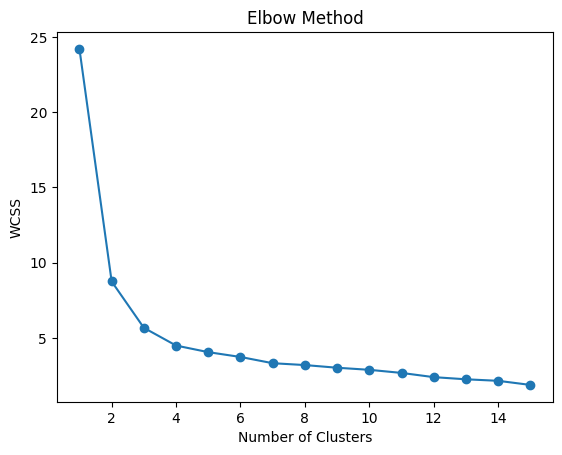

In [484]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from joblib import dump
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def extract_features(image_paths, model):
    features = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=(256, 256))  
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        feature = model.predict(image)
        features.append(feature.flatten())
    return np.array(features)

def load_model():
    base_model = InceptionV3(weights=None, include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
               if os.path.isfile(os.path.join(image_folder, f)) 
               and f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'))]
pretrained_model = load_model()
features = extract_features(image_paths, pretrained_model)

wcss = []
max_clusters = 15  
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_) 
    
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [488]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from joblib import dump
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters = 3
best_silhouette_score = -1  

for _ in range(3):
    pretrained_model = InceptionV3(weights=None, include_top=False)
    x = pretrained_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=pretrained_model.input, outputs=x)
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                   if os.path.isfile(os.path.join(image_folder, f)) 
                   and f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'))]
    features = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=(299, 299))  
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        feature = model.predict(image)
        features.append(feature.flatten())
    features = np.array(features)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    silhouette_avg = silhouette_score(features, kmeans.labels_)
    print(f"Silhouette Score: {silhouette_avg}")
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_features = features
        best_kmeans = kmeans
        dump(kmeans, kmeans_model_path)

print(f"Best Silhouette Score: {best_silhouette_score}")


1/1 [==============================] - 0s 57ms/step
Silhouette Score: 0.38215768337249756
1/1 [==============================] - 0s 58ms/step
Silhouette Score: 0.42719510197639465
1/1 [==============================] - 0s 59ms/step
Silhouette Score: 0.48548638820648193
Best Silhouette Score: 0.48548638820648193


In [489]:
import pandas as pd
csv_output_path = '../Application/data/cluster/'+folder_Name+'.csv'
image_cluster_mapping = pd.DataFrame({'Image_Path': image_paths, 'Cluster_Label': best_kmeans.labels_})
image_cluster_mapping.to_csv(csv_output_path, index=False)
print(f"Image-cluster mapping saved to {csv_output_path}")

Image-cluster mapping saved to ../Application/data/cluster/sattriya.csv


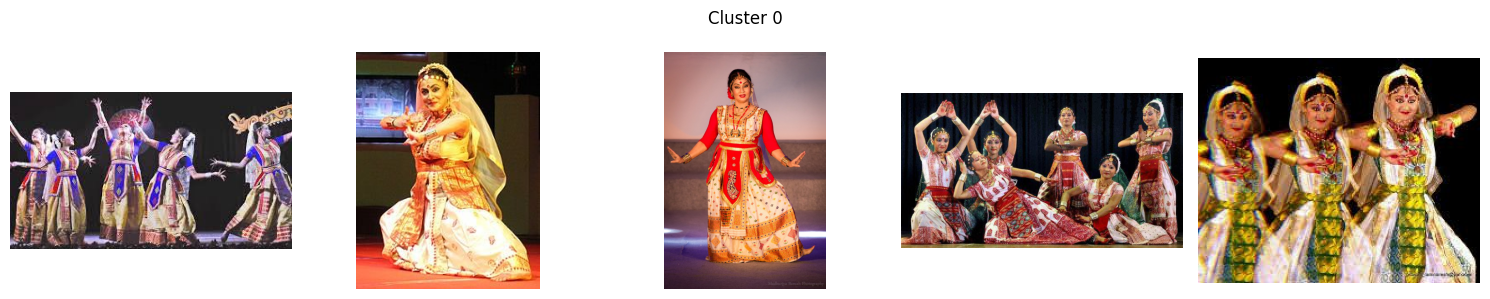

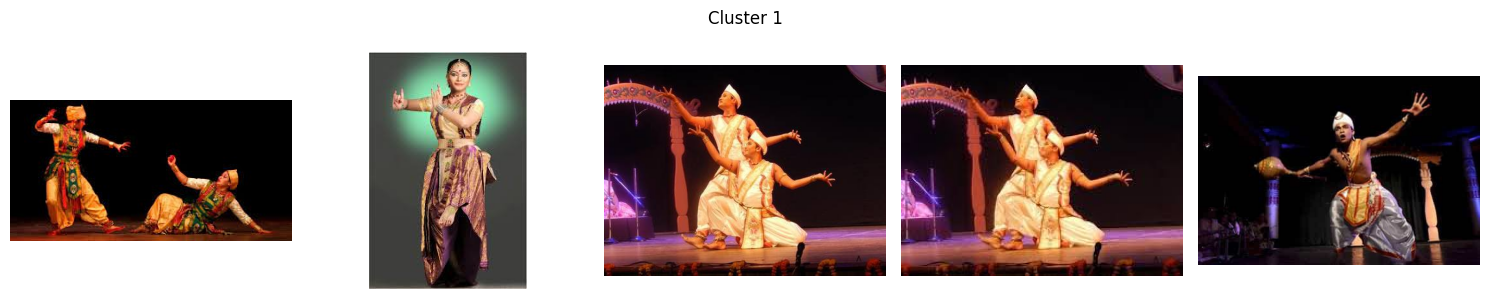

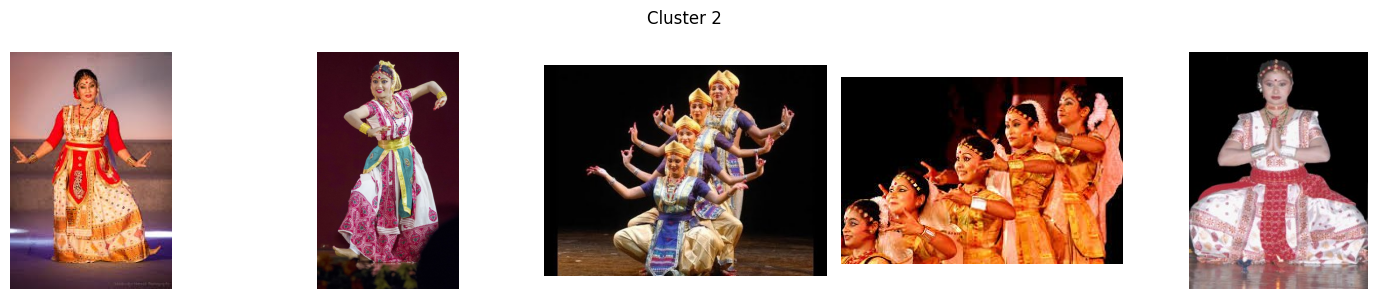

In [490]:
import pandas as pd
import matplotlib.pyplot as plt
import random

image_cluster_mapping = pd.read_csv(csv_output_path)
num_images_per_cluster = 5
cluster_groups = image_cluster_mapping.groupby('Cluster_Label')

for cluster_label, cluster_data in cluster_groups:
    random_images = cluster_data.sample(min(num_images_per_cluster, len(cluster_data)))
    fig, axes = plt.subplots(1, num_images_per_cluster, figsize=(15, 3))
    for i, (_, row) in enumerate(random_images.iterrows()):
        img = plt.imread(row['Image_Path'])
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.suptitle(f'Cluster {cluster_label}')
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 1s 1s/step
The image belongs to cluster: [2]


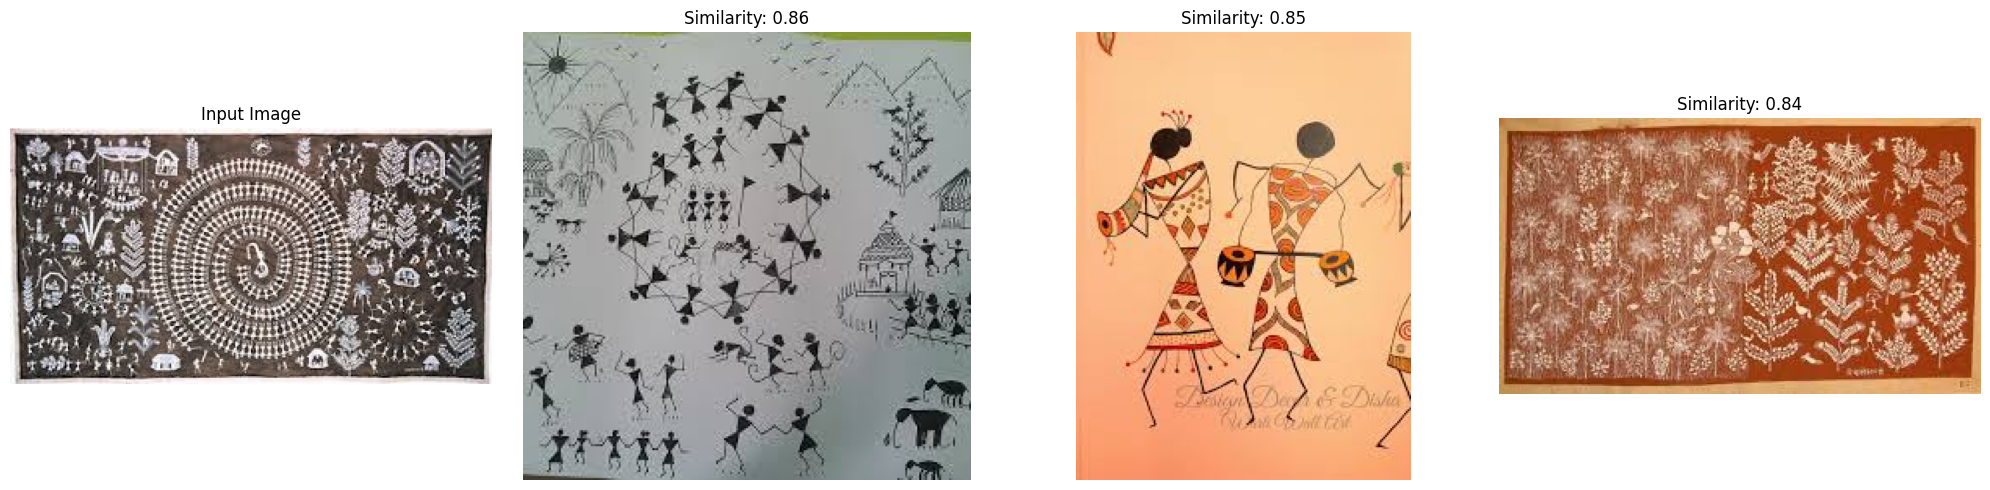

In [85]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.cluster import KMeans
import joblib
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image

kmeans_model_path = 'Warli.pkl'
kmeans_model = joblib.load(kmeans_model_path)
image_path = '../Image Data/Paintings/training/Warli/p2.jpg'
def preprocess_image(image_path, target_size=(299, 299)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image
pretrained_model = InceptionV3(weights=None, include_top=False)
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=pretrained_model.input, outputs=x)
image = preprocess_image(image_path)
image_features = model.predict(image)
cluster_label = kmeans_model.predict(image_features)
print(f"The image belongs to cluster: {cluster_label}")

csv_path = 'Image_clustering_CSV/Warli.csv'
df = pd.read_csv(csv_path)

def calculate_similarity(image_path1, image_path2):
    img1 = Image.open(image_path1).convert('RGB').resize((299, 299))
    img2 = Image.open(image_path2).convert('RGB').resize((299, 299))
    img1_array = np.array(img1).reshape(1, -1)
    img2_array = np.array(img2).reshape(1, -1)
    similarity = cosine_similarity(img1_array, img2_array)
    return similarity[0][0]

relevant_paths = df[df['Cluster_Label'] == cluster_label[0]]['Image_Path']
similarities = {}
for path in relevant_paths:
    similarity = calculate_similarity(image_path, path)
    similarities[path] = similarity

top_3_paths = sorted(similarities, key=lambda x: similarities[x], reverse=True)[:3]
fig, axes = plt.subplots(1, 4, figsize=(20, 5)) 
input_img = Image.open(image_path)
axes[0].imshow(input_img)
axes[0].set_title("Input Image")
axes[0].axis('off')
for i, path in enumerate(top_3_paths, 1):
    img = Image.open(path)
    axes[i].imshow(img)
    axes[i].set_title(f"Similarity: {similarities[path]:.2f}")
    axes[i].axis('off')

plt.tight_layout() 
plt.show()